In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, BisectingKMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, rand_score, calinski_harabasz_score, fowlkes_mallows_score

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 8

# Load data

In [2]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])
        
    

## Scale Inputs

In [3]:

# # concat flows
# scaled_flows = list(flows_dict.values())
# scaled_flows = pd.concat(scaled_flows, axis=0)

# # scaler = MinMaxScaler((-1,1))
# scaler = RobustScaler()
# scaler.fit(scaled_flows)
# scaled_flows = scaler.transform(scaled_flows)

# scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
# print(scaled_flows.shape)
# print(scaled_flows.head())

In [4]:
# concat flows
scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler = QuantileTransformer()
scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.970008     0.683780
1  0.002002  0.970002     0.683603
2  0.003003  0.969996     0.683443
3  0.004716  0.969991     0.683280
4  0.006006  0.969985     0.683114


# All Columns

In [5]:
# separate into file series
scaled_all = [scaled_flows.iloc[i*640:i*640+640, :] for i in range(len(scaled_flows) // 640)]
scaled_all = [flow.values for flow in scaled_all]
scaled_all = np.array([flow.ravel() for flow in np.array(scaled_all)])
scaled_all.shape

(11771, 1920)

In [6]:
scaled_all[0][:20]

array([0.        , 0.97000764, 0.6837804 , 0.002002  , 0.97000205,
       0.68360324, 0.00300301, 0.96999646, 0.68344318, 0.0047157 ,
       0.96999084, 0.68327998, 0.00600603, 0.96998522, 0.68311361,
       0.00700702, 0.96997958, 0.68294401, 0.00800806, 0.96997392])

## TSNE

In [7]:
tsne = TSNE(n_components=2)
transformed_all = tsne.fit_transform(scaled_all)
transformed_all.shape

(11771, 2)

<AxesSubplot: >

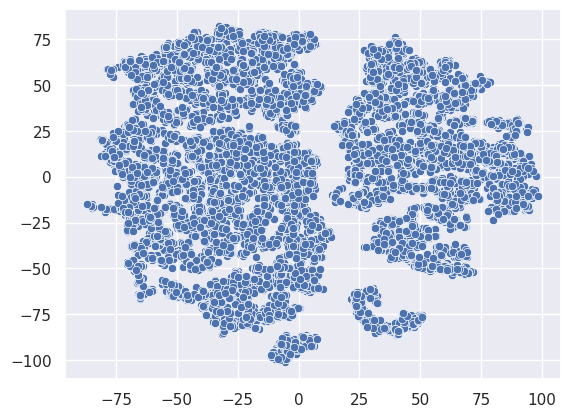

In [8]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1])

# Bissect K-Means

In [9]:
bikmeans = BisectingKMeans(n_clusters=3, random_state=1)
tsne_bik_labels = bikmeans.fit_predict(transformed_all)

In [10]:
clustering_metrics(BisectingKMeans, transformed_all, {"random_state": 1})

,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,2,0.384046,1.071121,7645.737204
1,3,0.409595,0.806739,10126.227666
2,4,0.389521,0.841753,10641.618047
3,5,0.346527,0.941021,9882.199181
4,6,0.334395,1.047298,9867.212299
5,7,0.297110,1.070532,9370.519612
6,8,0.305859,1.140805,9403.324931
7,9,0.300939,1.052603,9476.263874
8,10,0.297338,1.010921,9495.408849
9,11,0.315320,0.975261,9959.204138


<AxesSubplot: >

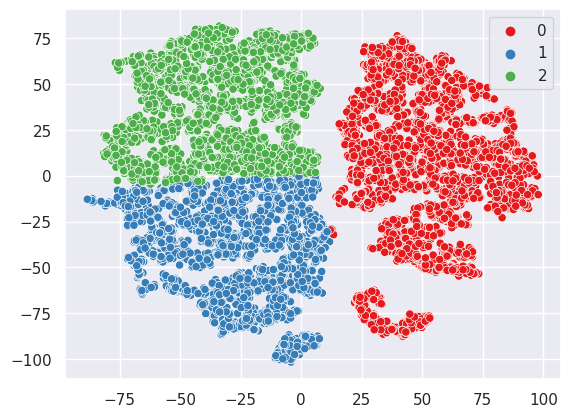

In [13]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=tsne_bik_labels, palette='Set1')

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

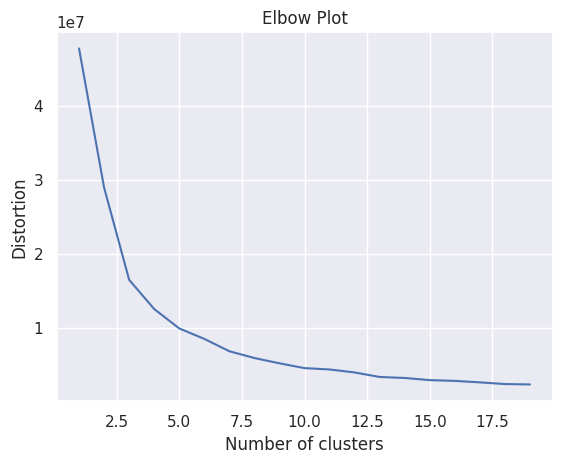

In [11]:
# Elbow Test
distortions = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_all)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

In [12]:
clustering_metrics(KMeans, transformed_all, {"max_iter": 5000, "n_init": 'auto'})

,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,2,0.339342,1.234598,6449.830393
1,3,0.428205,0.793604,11161.477230
2,4,0.394191,0.870915,11010.752011
3,5,0.376325,0.905653,11210.411433
4,6,0.391597,0.836150,11236.993240
5,7,0.401113,0.786914,11733.492946
6,8,0.360333,0.849285,10844.849278
7,9,0.393515,0.785347,12014.513801
8,10,0.382785,0.828889,11884.959142
9,11,0.405706,0.771407,12294.146334


In [13]:
kmeans = KMeans(n_clusters=3,max_iter=500, n_init='auto')
tsne_kmeans_labels = kmeans.fit_predict(scaled_all)
nclusters = len(set(tsne_kmeans_labels))

<AxesSubplot: >

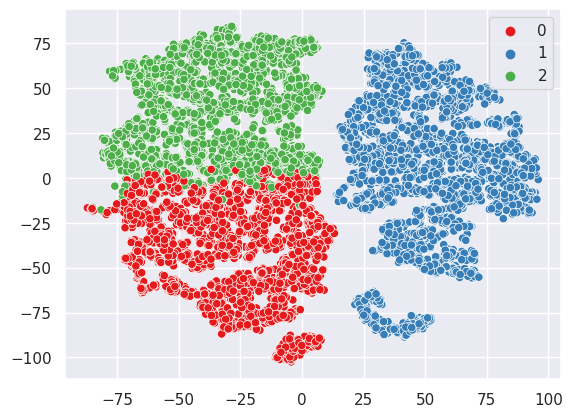

In [14]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=tsne_kmeans_labels, palette='Set1')

### Original Data

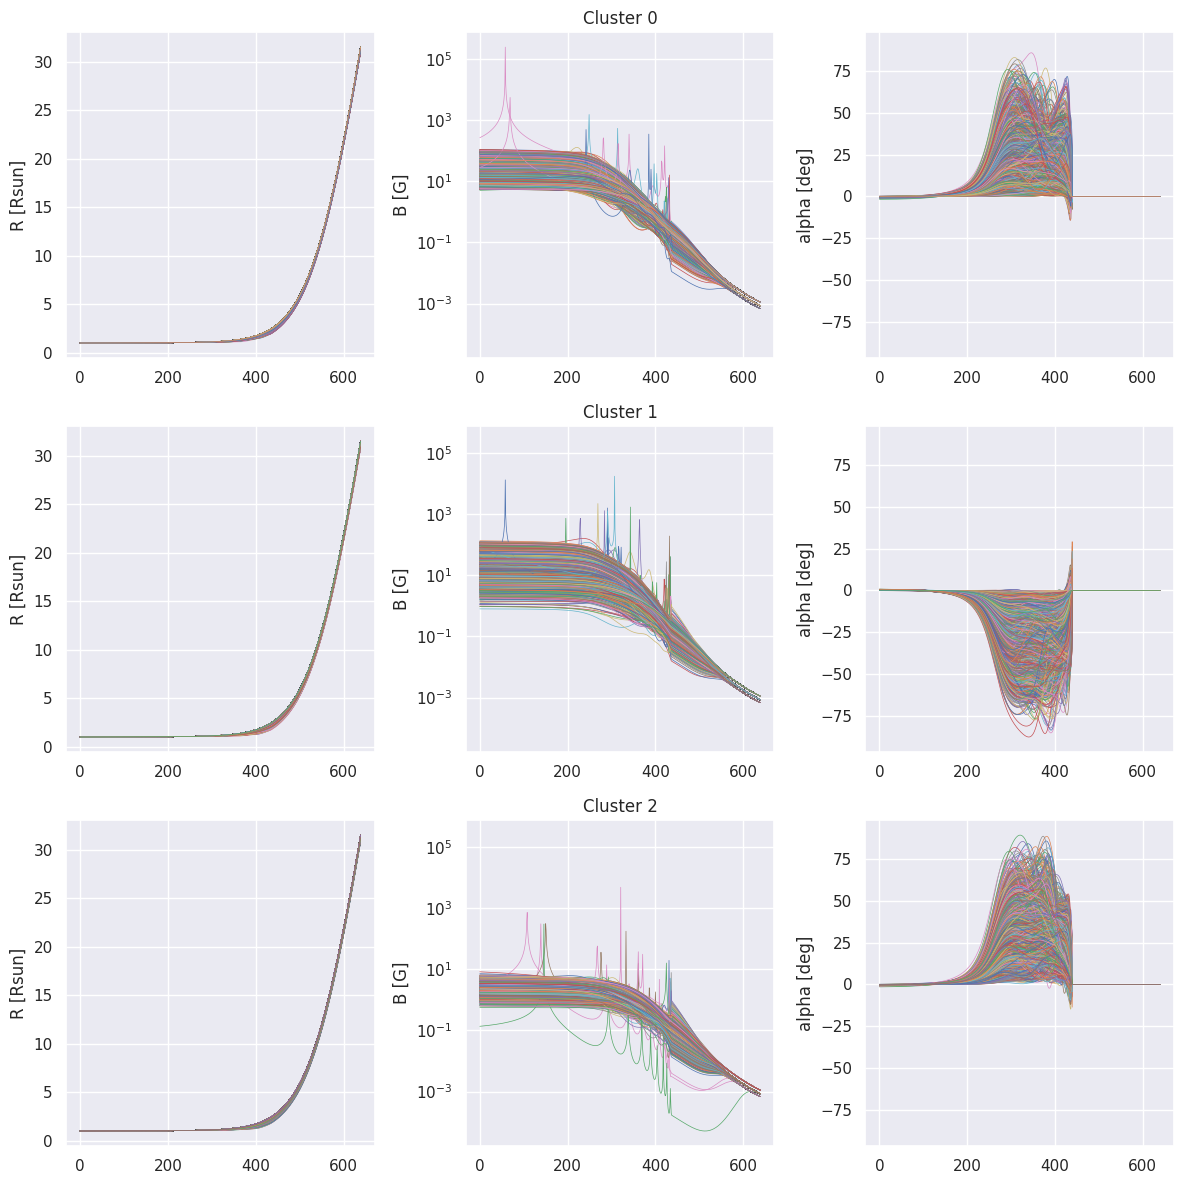

In [15]:
plot_unscaled_clusters(tsne_kmeans_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

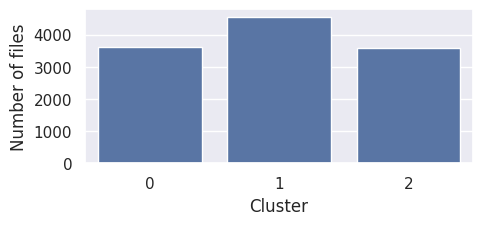

In [16]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=tsne_kmeans_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

{'CR1992': [1090, 1339, 71], 'CR2056': [750, 1298, 514], 'CR2071': [138, 1291, 744], 'CR2125': [638, 635, 790], 'CR2210': [1006, 0, 1467]}
[0, 1, 2]


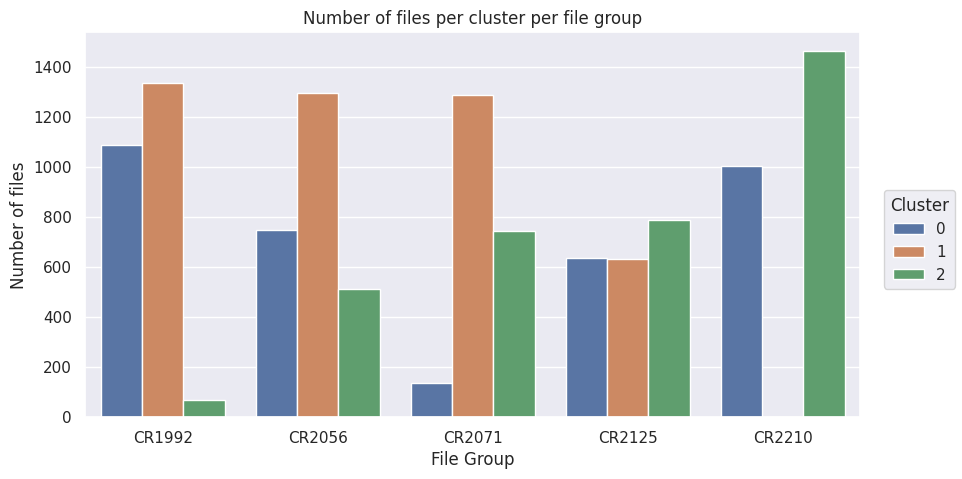

In [17]:
fig = plot_cluster_file_group(filenames, tsne_kmeans_labels, nclusters)

### Grid Search

In [15]:
# %%capture
# subdir = OUT_DIR / 'kmeans'
# if not subdir.exists():
#     subdir.mkdir(parents=True)
    
# for k in range(2, 5):
#     kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
#     kmeans_labels = kmeans.fit_predict(transformed_all)
    
#     sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=kmeans_labels, palette='Set1')
#     plt.savefig(subdir / f'scatter_{k}.png', dpi=200)
#     plot_unscaled_clusters(kmeans_labels, k, flows_dict, flow_columns, save_path=subdir / f'unscaled_{k}.png', yscale={'B [G]': 'log'})

## Hierarchical Clustering

In [9]:
clustering_metrics(AgglomerativeClustering, transformed_all, { "linkage": 'ward', "compute_full_tree": True, "compute_distances": True})

,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,2,0.372914,1.045752,7194.681467
1,3,0.395916,0.866383,9953.361476
2,4,0.363077,0.929480,9356.285806
3,5,0.330007,1.009330,9297.058519
4,6,0.318211,0.985485,9344.603540
5,7,0.340987,0.897670,9757.579593
6,8,0.334919,0.919154,9700.758419
7,9,0.346137,0.830775,9991.582306
8,10,0.351370,0.799380,10116.989162
9,11,0.344724,0.814220,10484.675778


For n_clusters = 2 The average silhouette_score is : 0.37291405
For n_clusters = 3 The average silhouette_score is : 0.3959155
For n_clusters = 4 The average silhouette_score is : 0.3630773
For n_clusters = 5 The average silhouette_score is : 0.3300068
For n_clusters = 6 The average silhouette_score is : 0.3182113
For n_clusters = 7 The average silhouette_score is : 0.34098694
For n_clusters = 8 The average silhouette_score is : 0.33491945
For n_clusters = 9 The average silhouette_score is : 0.34613714
For n_clusters = 10 The average silhouette_score is : 0.35136974


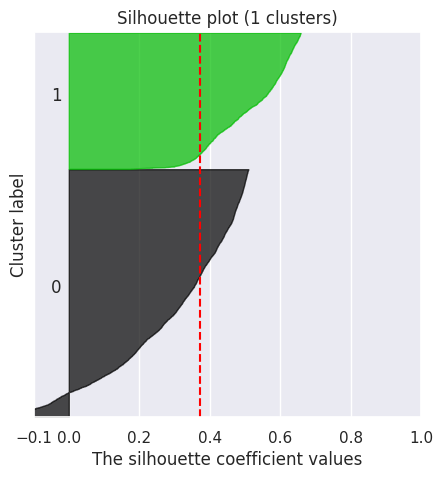

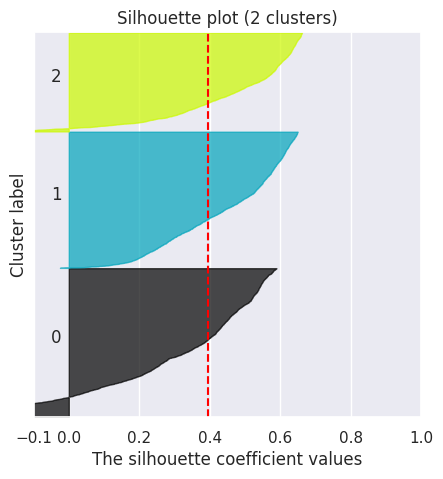

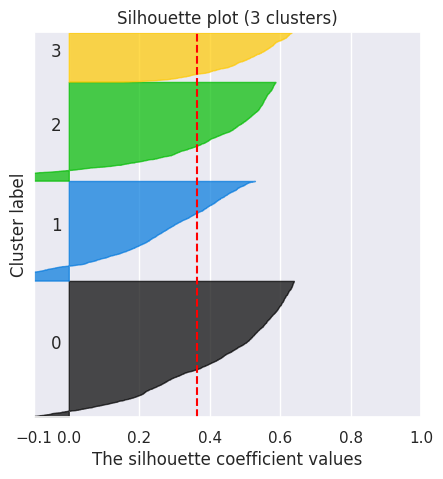

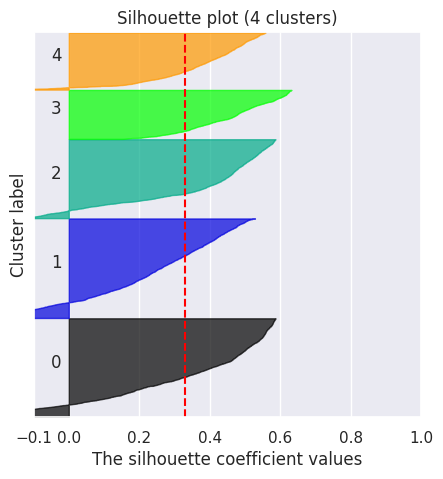

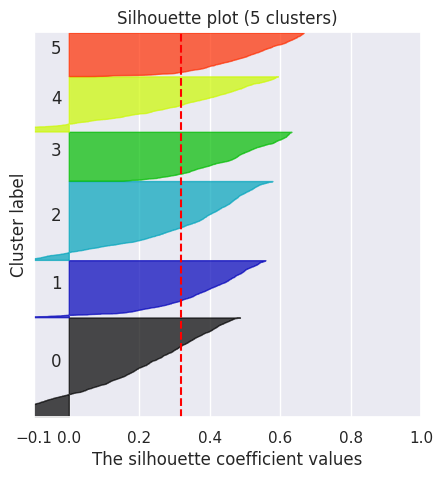

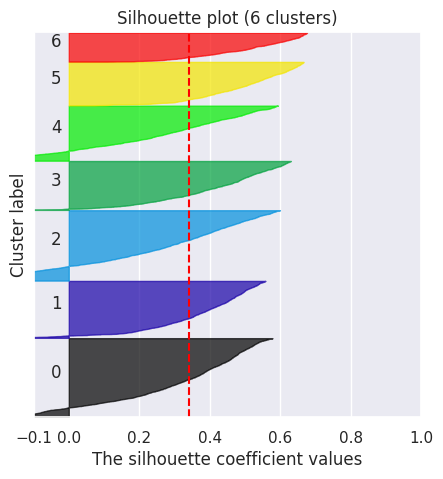

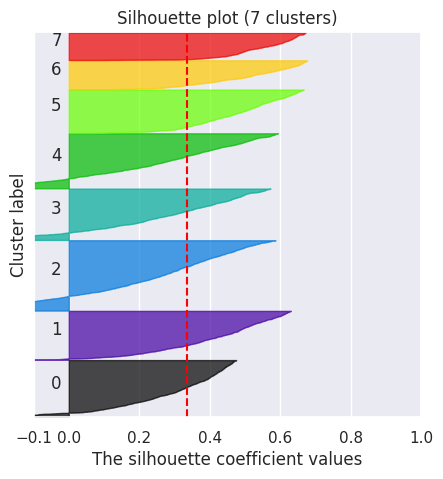

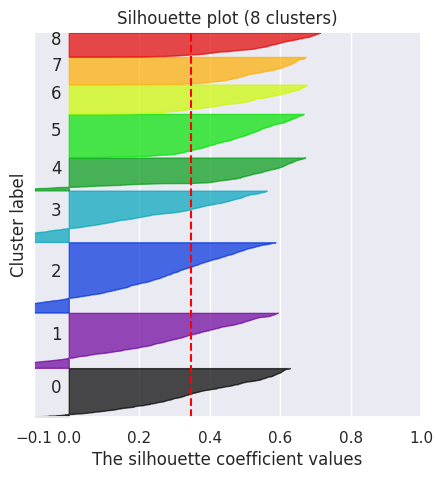

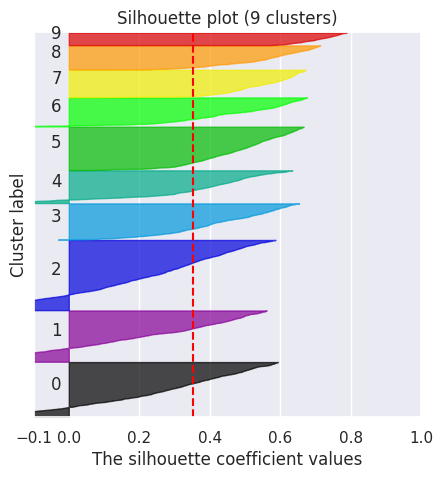

In [13]:
silhouette_plot(transformed_all,10, AgglomerativeClustering, params={"linkage": 'ward', "compute_full_tree": True, "compute_distances": True})

In [17]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='ward')
agg = agg.fit(transformed_all)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

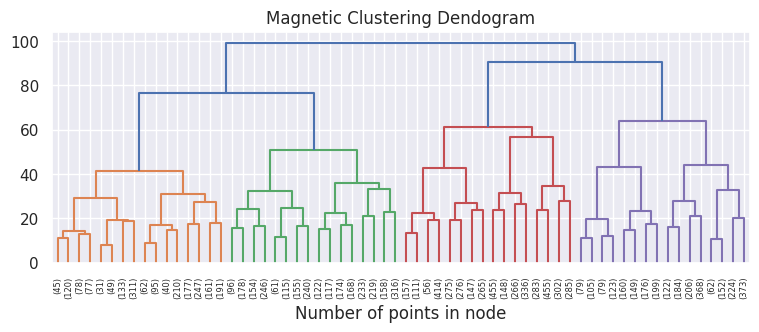

In [14]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=5)
plt.xlabel("Number of points in node")

,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,2,0.313988,1.234631,5653.235259
1,3,0.402437,0.847560,10029.657293
2,4,0.380542,0.777788,9713.101203
3,5,0.371366,0.863507,10636.324137
4,6,0.356122,0.910911,10284.799447
5,7,0.329889,1.011313,9541.482206
6,8,0.335752,0.942074,9766.761886
7,9,0.346446,0.908970,10126.646560
8,10,0.366346,0.818891,10669.676706
9,11,0.363946,0.838421,11207.402432


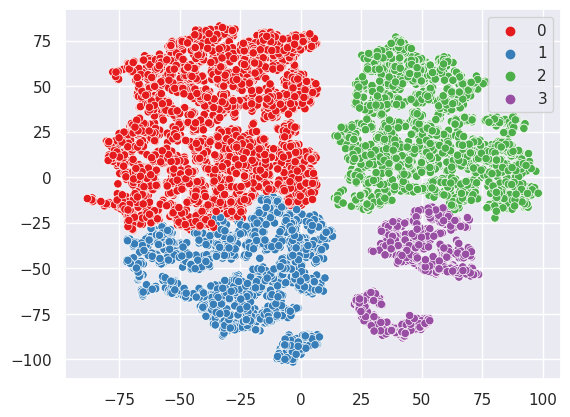

In [18]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

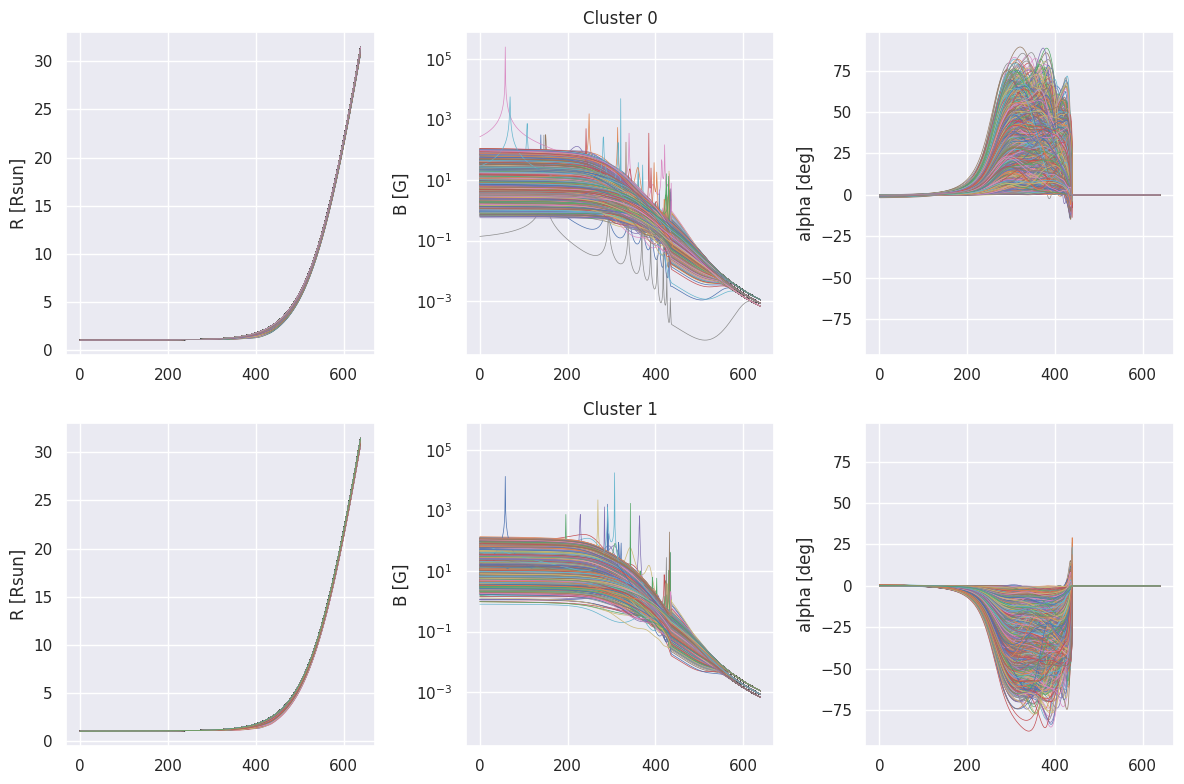

In [21]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

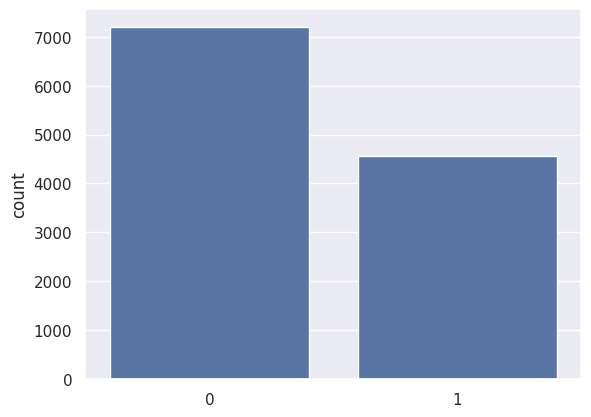

In [22]:
sns.countplot(x=agg.labels_, color='b')

{'CR1992': [1161, 1339], 'CR2056': [1264, 1298], 'CR2071': [882, 1291], 'CR2125': [1428, 635], 'CR2210': [2473, 0]}
[0, 1]


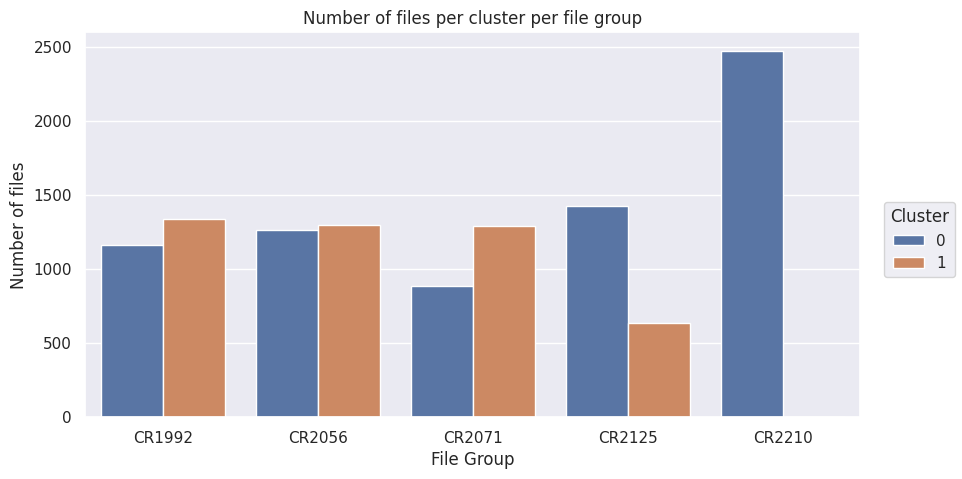

In [23]:
fig = plot_cluster_file_group(filenames, agg.labels_, nclusters)

### Grid Search

In [24]:
# %%capture
# sub_dir = OUT_DIR / 'hierarchical'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_all)
    
#     sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1') 
#     plt.savefig(sub_dir / f'scatter_{i}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, i, flows_dict, flow_columns, save_path=sub_dir / f'unscaled_{i}.png', yscale={'B [G]': 'log'}) 
    